In [1]:
using StaticArrays, ProgressMeter
include("../code/headers.jl")

# 1. Decimation

In [2]:
function decimate!(sp, src; decsteps=10, freevars=collect(1:size(sp.H,2)), kw...)
    iteration!(sp; maxiter=1000, damp=0.5, kw...)
    cnt = 0
    maxvardeg = maximum(sum(sp.H, dims=1))
    while !isempty(freevars)
        cnt += 1
        ε = iteration!(sp; maxiter=100, damp=0.5, kw...)
        # rank variables with the most decided at the end
        mag = [findmax([sum(p[begin:-1]), sum(p[1:end])]) for p in sp.survey]
        mag_sign = [(m[2] - 1.5)*2 for m in mag]
        sort!(freevars, by=i->abs(mag[i][1]))
        # fix the highest-ranked with a strong field
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps+1):end]
        println("Step $cnt - fixing: $tofix")
        sp.efield[tofix] .= (maxvardeg+1)*sp.J.*mag_sign[tofix]  
        # print stuff
        σ = sign.(argmax.(sp.survey))
        x = σ .== -1
        z = sp.H*x .% 2
        ovl = dot(σ, src) / length(src)
        println("Unsat ", sum(z), ". Free vars ", length(freevars), ". Ovl ", round(ovl,digits=3),
            ". ε=", round(ε,sigdigits=3))
    end
end

decimate! (generic function with 1 method)

In [3]:
m = factorial(7)
R = 0.25
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
# convert to edge degree convention to express the degree profile
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
# build graph
H = ldpc_graphGF2(n,m,nedges,lambda,rho).H
x0 = rand((0,1), size(H,2))
src = (-1).^x0
J = 20
# init=OffsetArray(MVector{2J+1}(fill(1/(2J+1),2J+1)), -J:J)
init=OffsetArray(MVector{2J+1}(rand(2J+1)), -J:J)
y = 0.2
sp = survey_propagation(H; field=src, init, y=y);

In [6]:
decimate!(sp, src, decsteps=1)

Step 1 - fixing: [2660]
Unsat 443.0. Free vars 6718. Ovl 0.6081845238095238
Step 2 - fixing: [3440]
Unsat 445.0. Free vars 6716. Ovl 0.6160714285714286
Step 3 - fixing: [1249]
Unsat 450.0. Free vars 6714. Ovl 0.625297619047619
Step 4 - fixing: [5720]
Unsat 450.5. Free vars 6712. Ovl 0.6342261904761904
Step 5 - fixing: [4509]
Unsat 449.5. Free vars 6710. Ovl 0.6430059523809524
Step 6 - fixing: [2877]
Unsat 453.5. Free vars 6708. Ovl 0.6522321428571428
Step 7 - fixing: [1025]
Unsat 453.5. Free vars 6706. Ovl 0.6610119047619047
Step 8 - fixing: [135]
Unsat 452.5. Free vars 6704. Ovl 0.6699404761904761


LoadError: TaskFailedException:
InterruptException:
Stacktrace:
 [1] Array at ./boot.jl:406 [inlined]
 [2] Array at ./boot.jl:415 [inlined]
 [3] Array at ./boot.jl:423 [inlined]
 [4] similar at /home/crotti/.julia/packages/OffsetArrays/PXUn7/src/OffsetArrays.jl:244 [inlined]
 [5] fill(::Float64, ::Tuple{UnitRange{Int64}}) at /home/crotti/.julia/packages/OffsetArrays/PXUn7/src/OffsetArrays.jl:248
 [6] fill at ./array.jl:471 [inlined]
 [7] ⊛(::OffsetArray{Float64,1,Array{Float64,1}}, ::OffsetArray{Float64,1,Array{Float64,1}}) at /home/crotti/sourcecoding/code/sp.jl:28
 [8] cavity!(::Array{OffsetArray{Float64,1,Array{Float64,1}},1}, ::Array{OffsetArray{Float64,1,Array{Float64,1}},1}, ::typeof(⊛), ::OffsetArray{Float64,1,Array{Float64,1}}) at /home/crotti/sourcecoding/code/cavity.jl:25
 [9] update_var!(::SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}}, ::Int64; damp::Float64, rein::Float64) at /home/crotti/sourcecoding/code/sp.jl:90
 [10] macro expansion at /home/crotti/sourcecoding/code/sp.jl:357 [inlined]
 [11] (::var"#244#threadsfor_fun#432"{Float64,Float64,SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}},Array{Float64,1},UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [12] (::var"#244#threadsfor_fun#432"{Float64,Float64,SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}},Array{Float64,1},UnitRange{Int64}})() at ./threadingconstructs.jl:48

In [ ]:
HH(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = PyPlot.subplots(figsize=(6,5))
PyPlot.xlabel("Rate")
PyPlot.ylabel("Distortion")
PyPlot.plot((0,1),(0.5,0), label="trival")
PyPlot.plot(HH.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
PyPlot.plot(1-α,dist, "*", label="SP with decimation: 63 UNSAT")
legend()

# 2. Decimation on basis

In [8]:
B,indep = findbasis_slow(Array(H))
iszero(H*sparse(B) .% 2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


true

In [9]:
sp = survey_propagation(H; field=src, init, y=y)
maxvardeg = maximum(sum(sp.H, dims=1))
sp.efield[indep] .= (maxvardeg+1)*sp.J.*rand((-1,1), length(indep));

In [10]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration!(sp; maxiter=1000, damp=0.1, callback=callback, tol=1e-10)

1 0.9580594315840467
2 0.3130182545689111
3 0.6608418369374909
4 0.7203630537306152
5 0.6561673127556215
6 0.538838388865429
7 0.4957943181919655
8 0.5387624982828829
9 0.5031901862158192
10 0.49334580026487707
11 0.5673415988535153
12 0.5334851781380087
13 0.4661683068770158
14 0.42617878926467295
15 0.40996023620898253
16 0.3933277321583886
17 0.32985482361193463
18 0.311833956252111
19 0.2963175139491933
20 0.2878537732511053
21 0.21059526398616857
22 0.11928766475910091
23 0.05645890736626613
24 0.023320019730688757
25 0.008637736810220065
26 0.00292377594365989
27 0.0009174432139830158
28 0.00026997739774126117
29 7.523334540127102e-5
30 2.0019941459392676e-5
31 5.124494432795501e-6
32 1.2697932371130705e-6
33 3.062519542407216e-7
34 7.222180575805481e-8
35 1.671402660718968e-8
36 3.806215231882959e-9
37 8.544569496393706e-10
38 1.8929202649786703e-10
39 4.140221498971641e-11


LoadError: UndefVarError: ε not defined

In [11]:
σ = sign.(argmax.(sp.survey))
x = σ .== -1
z = sp.H*x .% 2
nunsat = sum(z)

1622

In [12]:
countmap(σ)

Dict{Int64,Int64} with 3 entries:
  0  => 3
  -1 => 3368
  1  => 3349

Check whether all fixed variables actually took those values

In [93]:
fields = sign.(sp.efield[indep])
surveys = sign.(argmax.(sp.survey[indep]))
sum(fields .!= surveys)

0

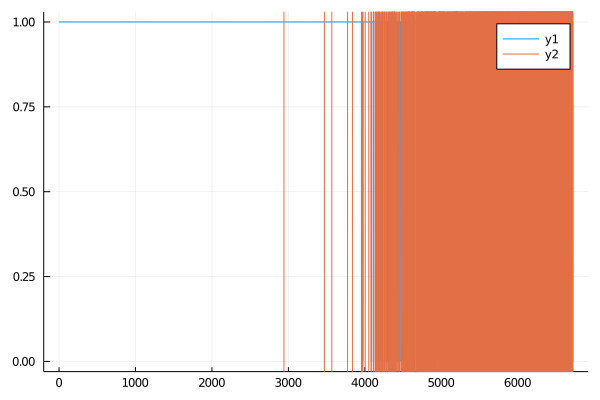

In [23]:
isdelta(p) = (maximum(p)≈1)
plot  (1:n, isdelta.(sp.survey))
dep = setdiff(1:n,indep)
vline!(dep)

In [ ]:
# function decimate_basis!(sp, s, indep; decsteps=10, freevars=collect(1:size(sp.H,2)), kw...)
#     iteration!(sp; maxiter=1000, damp=0.5, kw...)
#     cnt = 0
#     maxvardeg = maximum(sum(sp.H, dims=2))
#     while !isempty(freevars)
#         cnt += 1
#         iteration!(sp; maxiter=100, damp=0.5, kw...)
#         # rank variables
#         mag = [findmax([sum(p[begin:-1]), sum(p[1:end])]) for p in sp.survey]
#         mag_sign = [(m[2] - 1.5)*2 for m in mag]
#         sort!(freevars, by=i->abs(mag[i][1]))
#         # fix the highest-ranked with a strong field
#         freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps+1):end]
#         println("Step $cnt - fixing: $tofix")
#         sp.efield[tofix] .= maxvardeg*sp.J.*mag_sign[tofix]  
#         # print stuff
#         σ = sign.(argmax.(sp.survey))
#         x = (1 .- σ)/2
#         z = sp.H*x .% 2
#         ovl = dot(σ, s) / length(s)
#         println("Unsat ", sum(z), ". Free vars ", length(freevars), ". Ovl ", round(ovl,digits=3))
#     end
# end